<a href="https://colab.research.google.com/github/nikhildhavale/pythonLearning/blob/main/knm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

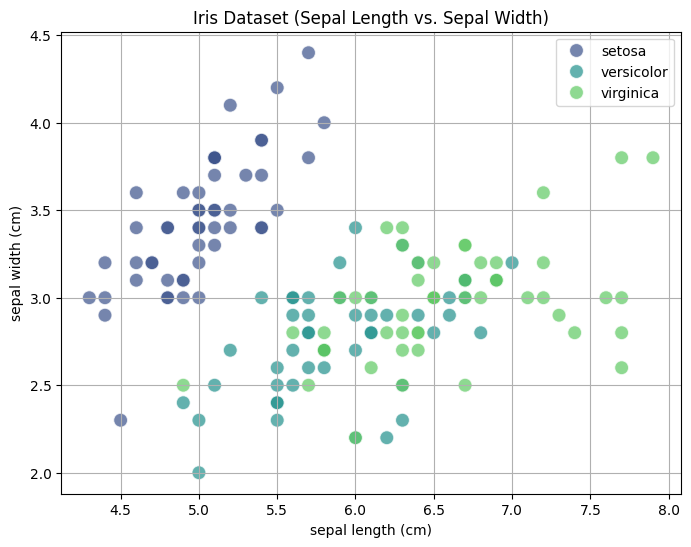

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import numpy as np

# Visualize the Iris dataset (first two features for simplicity)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=iris.target_names[y], palette='viridis', s=100, alpha=0.7)
plt.title('Iris Dataset (Sepal Length vs. Sepal Width)')
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# K-Nearest Neighbors: Classification (Breast Cancer) & Regression (Diabetes)
# Includes baseline models, scaling, GridSearchCV, RandomizedSearchCV, and PCA-based 2D decision visualization.
# Requires scikit-learn, pandas, numpy, matplotlib.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer, load_diabetes
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.decomposition import PCA

plt.rcParams["figure.figsize"] = (9, 6)
np.random.seed(42)


def regression_report(y_true, y_pred, label=""):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{label}MAE : {mae:.3f}")
    print(f"{label}MSE : {mse:.3f}")
    print(f"{label}RMSE: {rmse:.3f}")
    print(f"{label}R^2 : {r2:.4f}")


# -------------------------
# PART A — KNN CLASSIFICATION (Breast Cancer)
# -------------------------
print("\n=== KNN Classifier: Breast Cancer ===\n")
bc = load_breast_cancer()
X_bc, y_bc = bc.data, bc.target
print("Dataset shape (features, samples):", X_bc.shape)

# Train-test split (stratify for class balance)
Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    X_bc, y_bc, test_size=0.2, random_state=42, stratify=y_bc
)

# Scaling: fit scaler on train, apply to train & test
scaler_clf = StandardScaler()
Xb_train_scaled = scaler_clf.fit_transform(Xb_train)
Xb_test_scaled  = scaler_clf.transform(Xb_test)

# Baseline KNN classifier (k=5 default)
knn_clf = KNeighborsClassifier(n_neighbors=5, weights='uniform', p=2, n_jobs=-1)
knn_clf.fit(Xb_train_scaled, yb_train)
print("Baseline KNN trained.")

# Baseline evaluation
y_train_pred = knn_clf.predict(Xb_train_scaled)
y_test_pred  = knn_clf.predict(Xb_test_scaled)
print(f"Train acc: {accuracy_score(yb_train, y_train_pred):.4f}  |  Test acc: {accuracy_score(yb_test, y_test_pred):.4f}")
print("\nClassification report (Test):")
print(classification_report(yb_test, y_test_pred, target_names=bc.target_names))

# Confusion matrix
cm = confusion_matrix(yb_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=bc.target_names)
fig, ax = plt.subplots(figsize=(5,4))
disp.plot(ax=ax, cmap="Blues", values_format='d')
plt.title("KNN Classifier — Confusion Matrix (Test)")
plt.show()


# -------------------------
# Optional: PCA-based 2D decision region visualization (approximate)
# -------------------------
# This projects features to 2 principal components and plots decision regions of the trained KNN.
# It's an approximation (visual aid) because KNN was trained on full-dim data, but fine for demos.
print("\nPCA 2D visualization (approx) — projecting scaled data to first 2 PCs.")
pca = PCA(n_components=2, random_state=42)
Xb_train_2d = pca.fit_transform(Xb_train_scaled)
Xb_test_2d  = pca.transform(Xb_test_scaled)

# Fit a KNN on the 2D projection purely for visualization of decision regions
vis_knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', p=2)
vis_knn.fit(Xb_train_2d, yb_train)

# Create meshgrid
x_min, x_max = Xb_train_2d[:,0].min()-1, Xb_train_2d[:,0].max()+1
y_min, y_max = Xb_train_2d[:,1].min()-1, Xb_train_2d[:,1].max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = vis_knn.predict(grid).reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.2)
plt.scatter(Xb_train_2d[:,0], Xb_train_2d[:,1], c=yb_train, s=30, edgecolor='k', label='train')
plt.scatter(Xb_test_2d[:,0], Xb_test_2d[:,1], c=yb_test, s=50, marker='*', edgecolor='k', label='test')
plt.title("KNN decision regions on PCA(2) projection (visualization)")
plt.legend()
plt.show()


# -------------------------
# GridSearchCV for KNN (Classifier)
# -------------------------
print("\n--- GridSearchCV for KNN Classifier ---")
param_grid_knn_clf = {
    "n_neighbors": [3, 5, 7, 9, 11, 13, 15, 17],
    "weights": ["uniform", "distance"],
    "p": [1, 2]  # p=1 -> Manhattan, p=2 -> Euclidean
}
grid_knn_clf = GridSearchCV(
    KNeighborsClassifier(n_jobs=-1),
    param_grid=param_grid_knn_clf,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)
t0 = time.time()
grid_knn_clf.fit(Xb_train_scaled, yb_train)
t1 = time.time()
print(f"GridSearch finished in {t1-t0:.1f}s")
print("Best params (knn clf):", grid_knn_clf.best_params_)
print("Best CV score (knn clf):", f"{grid_knn_clf.best_score_:.4f}")

best_knn_clf = grid_knn_clf.best_estimator_
y_test_pred_grid = best_knn_clf.predict(Xb_test_scaled)
print(f"Test acc (best grid): {accuracy_score(yb_test, y_test_pred_grid):.4f}")


# -------------------------
# RandomizedSearchCV for KNN (Classifier)
# -------------------------
print("\n--- RandomizedSearchCV for KNN Classifier ---")
param_dist_knn_clf = {
    "n_neighbors": [1,3,5,7,9,11,13,15,17,19,21,23],
    "weights": ["uniform", "distance"],
    "p": [1, 2]
}
rand_knn_clf = RandomizedSearchCV(
    KNeighborsClassifier(n_jobs=-1),
    param_distributions=param_dist_knn_clf,
    n_iter=30,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    random_state=42,
    verbose=1
)
t0 = time.time()
rand_knn_clf.fit(Xb_train_scaled, yb_train)
t1 = time.time()
print(f"RandomizedSearch finished in {t1-t0:.1f}s")
print("Best params (rand knn clf):", rand_knn_clf.best_params_)
print("Best CV score (rand knn clf):", f"{rand_knn_clf.best_score_:.4f}")
best_rand_knn_clf = rand_knn_clf.best_estimator_
print(f"Test acc (best rand): {accuracy_score(yb_test, best_rand_knn_clf.predict(Xb_test_scaled)):.4f}")


# -------------------------
# PART B — KNN REGRESSION (Diabetes)
# -------------------------
print("\n\n=== KNN Regressor: Diabetes ===\n")
db = load_diabetes()
X_db, y_db = db.data, db.target.astype(float)
print("Dataset shape (regression):", X_db.shape)

# Train-test split
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_db, y_db, test_size=0.2, random_state=42)

# Scaling
scaler_reg = StandardScaler()
Xr_train_scaled = scaler_reg.fit_transform(Xr_train)
Xr_test_scaled  = scaler_reg.transform(Xr_test)

# Baseline KNN regressor
knn_reg = KNeighborsRegressor(n_neighbors=5, weights='uniform', p=2, n_jobs=-1)
knn_reg.fit(Xr_train_scaled, yr_train)
print("Baseline KNN regressor trained.")

# Baseline evaluation
y_pred_train = knn_reg.predict(Xr_train_scaled)
y_pred_test  = knn_reg.predict(Xr_test_scaled)
print("\nBaseline regressor performance:")
regression_report(yr_test, y_pred_test, label="Baseline Test ")


# -------------------------
# GridSearchCV for KNN (Regressor)
# -------------------------
print("\n--- GridSearchCV for KNN Regressor ---")
param_grid_knn_reg = {
    "n_neighbors": [3,5,7,9,11,15],
    "weights": ["uniform", "distance"],
    "p": [1, 2]
}
grid_knn_reg = GridSearchCV(
    KNeighborsRegressor(n_jobs=-1),
    param_grid=param_grid_knn_reg,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    verbose=1
)
t0 = time.time()
grid_knn_reg.fit(Xr_train_scaled, yr_train)
t1 = time.time()
print(f"GridSearch finished in {t1-t0:.1f}s")
print("Best params (knn reg):", grid_knn_reg.best_params_)
print("Best CV R^2 (knn reg):", f"{grid_knn_reg.best_score_:.4f}")

best_knn_reg = grid_knn_reg.best_estimator_
y_test_pred_grid_reg = best_knn_reg.predict(Xr_test_scaled)
print("\nTest performance (best grid):")
regression_report(yr_test, y_test_pred_grid_reg, label="Test ")


# -------------------------
# RandomizedSearchCV for KNN (Regressor)
# -------------------------
print("\n--- RandomizedSearchCV for KNN Regressor ---")
param_dist_knn_reg = {
    "n_neighbors": [1,3,5,7,9,11,15,20,25],
    "weights": ["uniform", "distance"],
    "p": [1, 2]
}
rand_knn_reg = RandomizedSearchCV(
    KNeighborsRegressor(n_jobs=-1),
    param_distributions=param_dist_knn_reg,
    n_iter=12,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    random_state=42,
    verbose=1
)
t0 = time.time()
rand_knn_reg.fit(Xr_train_scaled, yr_train)
t1 = time.time()
print(f"RandomizedSearch finished in {t1-t0:.1f}s")
print("Best params (rand knn reg):", rand_knn_reg.best_params_)
print("Best CV R^2 (rand knn reg):", f"{rand_knn_reg.best_score_:.4f}")

best_rand_knn_reg = rand_knn_reg.best_estimator_
y_test_pred_rand_reg = best_rand_knn_reg.predict(Xr_test_scaled)
print("\nTest performance (best random):")
regression_report(yr_test, y_test_pred_rand_reg, label="Test ")

print("\nKNN experiments complete.")